## Домашняя работа по уроку 5 (Задача оттока)

Задача прогнозирования оттока клиентов банка

In [51]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import itertools

from sklearn.metrics import auc, f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt

%matplotlib inline

In [52]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [53]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [54]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [55]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [56]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [57]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [58]:
'''
Изменил данный блок на фунцию для того, чтобы стандартизация числовых признаков производилась только для
для модели логистической регрессии, т.к. это сказывается на результат работы и других моделей
model - признак модели. 1-логистическая регрессия, 0-все остальные
'''
def feature_processing(model=0):
    final_transformers = list()

    for cat_col in categorical_columns:
        cat_transformer = Pipeline([
                    ('selector', FeatureSelector(column=cat_col)),
                    ('ohe', OHEEncoder(key=cat_col))
                ])
        final_transformers.append((cat_col, cat_transformer))

    for cont_col in continuous_columns:
        if model == 1:
            cont_transformer = Pipeline([
                        ('selector', NumberSelector(key=cont_col)),
                        ('scaler', MinMaxScaler())
                    ])
        else:
            cont_transformer = Pipeline([
                        ('selector', NumberSelector(key=cont_col))
                    ])            
        final_transformers.append((cont_col, cont_transformer))

    feats = FeatureUnion(final_transformers)

    return feats

In [59]:
# Функция рассчета показателей и формирования словаря для датафрейма
def get_metrics(model_name, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, roc_auc_score=%.3f, pr_auc=%.3f' % (
        thresholds[ix],
        fscore[ix],
        precision[ix],
        recall[ix],
        roc_auc_score(y_test, preds), 
        auc(recall, precision)))
    
    data = {'model':model_name,
        'Best Threshold':thresholds[ix],
        'F-Score':fscore[ix],
        'precision':precision[ix],
        'recall':recall[ix], 
        'roc_auc_score':roc_auc_score(y_test, preds),
        'pr_auc':auc(recall, precision)}
    
    return data

##### Задание 1
Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

###### RandomForestClassifier

In [60]:
feats = feature_processing()
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [61]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [62]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [63]:
data = get_metrics('RandomForestClassifier', preds)
stats = pd.DataFrame(data, index=[0])

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629, roc_auc_score=0.864, pr_auc=0.698


###### XGBClassifier

In [64]:
feats = feature_processing()
pipeline_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42, use_label_encoder=False)),
])

In [65]:
#обучим наш пайплайн
pipeline_xgb.fit(X_train, y_train)

[16:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [66]:
#наши прогнозы для тестовой выборки
preds_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

In [67]:
data = get_metrics('XGBClassifier', preds_xgb)
stats = stats.append(data, ignore_index=True)

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633, roc_auc_score=0.861, pr_auc=0.697


###### GradientBoostingClassifier

In [68]:
feats = feature_processing()
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [69]:
#обучим наш пайплайн
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [70]:
#наши прогнозы для тестовой выборки
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]

In [71]:
data = get_metrics('GradientBoostingClassifier', preds_gb)
stats = stats.append(data, ignore_index=True)

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, roc_auc_score=0.876, pr_auc=0.724


###### LogisticRegression

In [72]:
feats = feature_processing(1)
pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [73]:
#обучим наш пайплайн
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [74]:
#наши прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]

In [75]:
data = get_metrics('LogisticRegression', preds_lr)
stats = stats.append(data, ignore_index=True)

Best Threshold=0.286079, F-Score=0.509, Precision=0.460, Recall=0.570, roc_auc_score=0.771, pr_auc=0.476


##### Задание 2
Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [76]:
stats

,model,Best Threshold,F-Score,precision,recall,roc_auc_score,pr_auc
0,RandomForestClassifier,0.380000,0.640641,0.653061,0.628684,0.863502,0.698049
1,XGBClassifier,0.373318,0.625850,0.619231,0.632613,0.860916,0.696732
2,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.597250,0.875746,0.724044
3,LogisticRegression,0.286079,0.508772,0.459588,0.569745,0.771223,0.475987


In [77]:
stats.loc[stats['F-Score'] == max(stats['F-Score'])]

,model,Best Threshold,F-Score,precision,recall,roc_auc_score,pr_auc
2,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.59725,0.875746,0.724044


In [78]:
stats.loc[stats['roc_auc_score'] == max(stats['roc_auc_score'])]

,model,Best Threshold,F-Score,precision,recall,roc_auc_score,pr_auc
2,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.59725,0.875746,0.724044


In [79]:
stats.loc[stats['pr_auc'] == max(stats['pr_auc'])]

,model,Best Threshold,F-Score,precision,recall,roc_auc_score,pr_auc
2,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.59725,0.875746,0.724044


Лучший результат, как по показателю F-score, так и по показателю roc_auc_score без доп настроек параметров показала модель GradientBoostingClassifier. Соотношение количества меток классов 1 к 4, вполне можно использовать roc_auc_score, но, на всякий случай также рассчитал и pr_auc. По данному показателю модель GradientBoostingClassifier оказалась лучшей.

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

- Precison - это точность. Отражает ошибку 1го рода, т.е. долю объектов верно идентифицированных моделью, как положительные относительно всех объектов принятых ей, как положительные.
- Recall - полнота. Отражает ошибку 2го рода, т.е. долю объектов верно идентифицированных моделью, как положительные относительно ввсех положительных объектов выборки. Даные показатели имеют обратную зависимость. Если мы хотим увеличить один из них путем смещения порога, то второй будет снижаться.

In [80]:
# 2. Да можно, при этом precision будет существенно снижен
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(recall)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, roc_auc_score=%.3f, pr_auc=%.3f' % (
    thresholds[ix],
    fscore[ix],
    precision[ix],
    recall[ix],
    roc_auc_score(y_test, preds), 
    auc(recall, precision)))

Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000, roc_auc_score=0.864, pr_auc=0.698


In [81]:
# 3. Да можно, при этом recall будет существенно снижен
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(precision)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, roc_auc_score=%.3f, pr_auc=%.3f' % (
    thresholds[ix],
    fscore[ix],
    precision[ix],
    recall[ix],
    roc_auc_score(y_test, preds), 
    auc(recall, precision)))

Best Threshold=0.940000, F-Score=0.008, Precision=1.000, Recall=0.004, roc_auc_score=0.864, pr_auc=0.698


Отрисуем матрицу ошибок

In [82]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


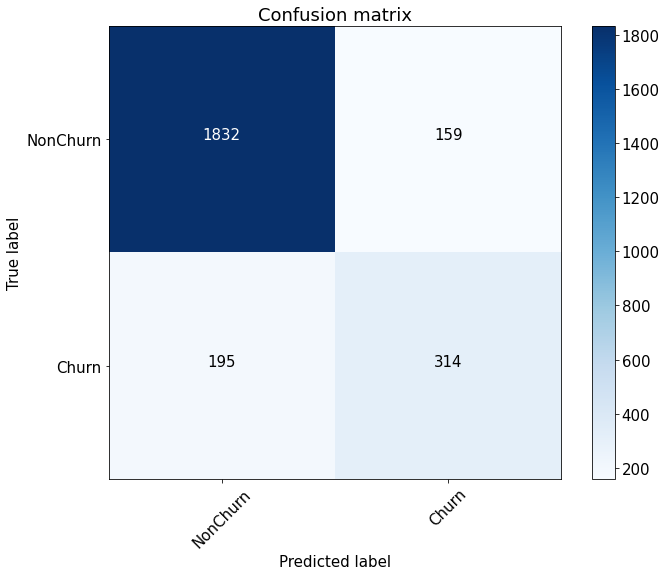

In [83]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

In [87]:
def prof(cnf_matrix):
    # Затраты на удержание = (FP+TP) * 1
    exp = cnf_matrix[0][1] + cnf_matrix[1][1]

    # Доход = TP * 2 (без учета того, что не все из верно определенных, как позитивные останутся с нами после взаимодействия)
    inc = cnf_matrix[1][1] * 2

    # Прибыль
    prof = inc - exp
    return prof

In [89]:
profit = prof(cnf_matrix)
profit

155

Итоговая прибыль для базовой модели составит 155 долларов, что для нас выгодно, соответственно, модель работает хорошо и удержание предсказанных ей покупателей целесообразно.

##### Задание 3
Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Confusion matrix, without normalization
[[1846  145]
 [ 202  307]]


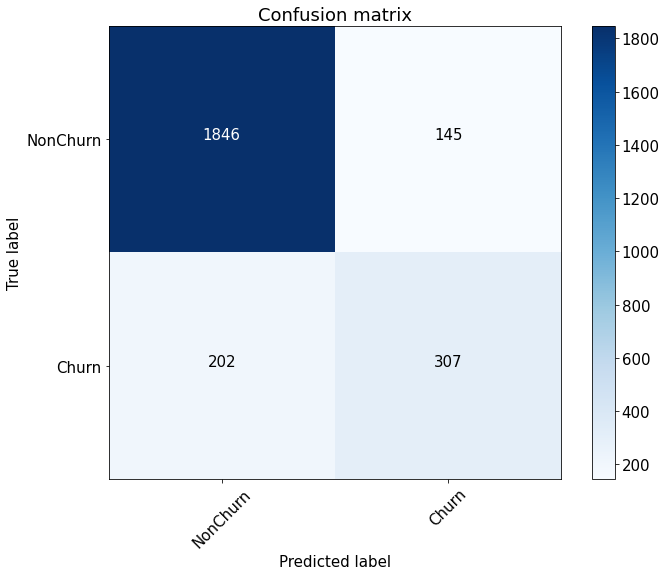

In [90]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [91]:
profit = prof(cnf_matrix)
profit

162

Для выбранной модели GradientBoostingClassifier итоговая прибыль составит 162 доллар, что больше, 155 базовой модели, соответственно, данная модель работает эффективней и удержание предсказанных ей покупателей еще более целесообразно.

##### Задание 4
(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

###### 1. перебор параметров с помощью GridSearch

Сетка с параметрами

In [93]:
from sklearn.model_selection import GridSearchCV

params = {
    "classifier__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "classifier__min_samples_leaf": [4,7,12,18],
    "classifier__max_depth":[5,8,12,15],
    "classifier__max_features":["log2","sqrt"],
    "classifier__subsample":[0.6, 0.7, 0.8],
    "classifier__n_estimators":[20, 50, 100, 150, 300]
    }

Запускаем перебор

In [97]:
# Ооооооочень долгий перебор
%%script_false
grid = GridSearchCV(pipeline_gb,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.075,
 'classifier__max_depth': 5,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 18,
 'classifier__n_estimators': 150,
 'classifier__subsample': 0.6}

In [94]:
# Best params:
# {'classifier__learning_rate': 0.075,
#  'classifier__max_depth': 5,
#  'classifier__max_features': 'log2',
#  'classifier__min_samples_leaf': 18,
#  'classifier__n_estimators': 150,
#  'classifier__subsample': 0.6}

Обучаем модель уже сновыми параметрами

In [95]:
feats = feature_processing()
pipeline_gb_gs = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(
        learning_rate=0.075,
        max_depth=5, 
        max_features='log2', 
        min_samples_leaf=18, 
        n_estimators=150, 
        subsample=0.6,
        random_state = 42)),])

In [96]:
#обучим наш пайплайн
pipeline_gb_gs.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [97]:
#наши прогнозы для тестовой выборки
preds_gb_gs = pipeline_gb_gs.predict_proba(X_test)[:, 1]

In [98]:
data = get_metrics('GradientBoostingClassifier_GS', preds_gb_gs)
stats = stats.append(data, ignore_index=True)

Best Threshold=0.315148, F-Score=0.649, Precision=0.615, Recall=0.688, roc_auc_score=0.872, pr_auc=0.719


In [99]:
stats

,model,Best Threshold,F-Score,precision,recall,roc_auc_score,pr_auc
0,RandomForestClassifier,0.380000,0.640641,0.653061,0.628684,0.863502,0.698049
1,XGBClassifier,0.373318,0.625850,0.619231,0.632613,0.860916,0.696732
2,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.597250,0.875746,0.724044
3,LogisticRegression,0.286079,0.508772,0.459588,0.569745,0.771223,0.475987
4,GradientBoostingClassifier_GS,0.315148,0.649351,0.615114,0.687623,0.872010,0.718636


После перебора параметров показатель F-Score немного увеличился, но roc_auc_score и pr_auc снизились

RandomeSearch работает схожим образом - настройки модели выбираются случайным образом из сетки гиперпараметров, поэтому не стал его добавлять. Попробовал использовать hyperopt, но что-то не задалось. Модуль постоянно выдавал различниые внутренние ошибки, с которым так же сталкивались и другие. Предпринятые меры не особо помогли, в т.ч. и откат к старым версиям модуля - просто изменились ошибки. Потом еще попробую разобраться, когда на это будет больше времени.

##### Задание 5
(опционально) Еще раз провести оценку экономической эффективности

Best Threshold=0.315148, F-Score=0.649, Precision=0.615, Recall=0.688
Confusion matrix, without normalization
[[1744  247]
 [ 162  347]]


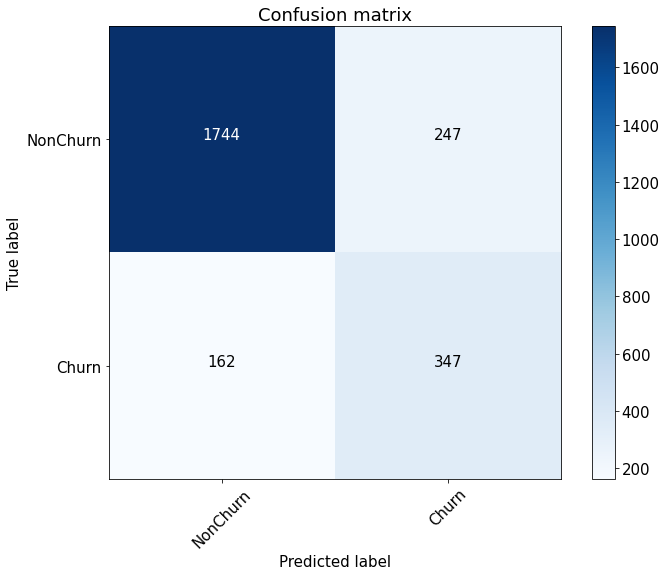

In [100]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb_gs)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [101]:
profit = prof(cnf_matrix)
profit

100

С экономической точки зрения полученная модель существенно менее эфффективна, чем модель на базовых настройках параметров